# Pubtrends-experimental

Experimental notebook for hypothesis testing and development purposes.

# Config

In [ ]:
import logging
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
from matplotlib import pyplot as plt
from bokeh.plotting import show, figure, output_file, save, reset_output, output_notebook
from bokeh.models import ColumnDataSource
from tqdm.auto import tqdm

from pysrc.config import PubtrendsConfig
from pysrc.papers.db.pm_postgres_loader import PubmedPostgresLoader
from pysrc.papers.utils import SORT_MOST_CITED

SEARCH_SORT = SORT_MOST_CITED
SEARCH_PAPERS = 10_000

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger('notebook')

# Avoid info message about compilation flags
# tf.get_logger().setLevel('ERROR')

output_notebook()

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Papers lookup

In [ ]:
from pysrc.papers.analyzer import PapersAnalyzer

config = PubtrendsConfig(test=False)
loader = PubmedPostgresLoader(config)
analyzer = PapersAnalyzer(loader, config)

## By titles

In [ ]:
titles = [
    "Heterogeneity of Aging: Individual Risk Factors, Mechanisms, Patient Priorities, and Outcomes",
    "A clinically meaningful metric of immune age derived from high-dimensional longitudinal monitoring",
    "Establishing Simultaneous T Cell Receptor Excision Circles (TREC) and K-Deleting Recombination Excision Circles (KREC) Quantification Assays and Laboratory Reference Intervals in Healthy Individuals of Different Age Groups in Hong Kong",
    "An analysis of the data collected by the status lymphaticus investigation committee",
    "Immunological function of the thymus",
    "Body computerized tomography and the thymus",
    "The thymus: reexamination of age-related changes in size and shape",
    "Age-stratified Patterns of Thymic Involution on Multidetector CT",
    "Maintenance of peripheral naive T cells is sustained by thymus output in mice but not humans",
    "Sparse production but preferential incorporation of recently produced naive T cells in the human peripheral pool",
    "Single-cell atlas of healthy human blood unveils age-related loss of NKG2C+GZMB-CD8+ memory T cells and accumulation of type 2 memory T cells",
    "Multiparameter flow cytometric analysis of CD4 and CD8 T cell subsets in young and old people",
    "A very low thymus function identifies patients with substantial increased risk for long-term mortality after kidney transplantation",
    "Effects of sex and aging on the immune cell landscape as assessed by single-cell transcriptomic analysis",
    "A human circulating immune cell landscape in aging and COVID-19",
    "Human PBMC scRNA-seq–based aging clocks reveal ribosome to inflammation balance as a single-cell aging hallmark and super longevity",
    "Comprehensive Profiling of an Aging Immune System Reveals Clonal GZMK+ CD8+ T Cells as Conserved Hallmark of Inflammaging",
    "The biology of recent thymic emigrants",
    "Reinterpreting recent thymic emigrant function: defective or adaptive?",
    "Reevaluation of T cell receptor excision circles as a measure of human recent thymic emigrants",
    "Changes in thymic function with age and during the treatment of HIV infection",
    "Two subsets of naive T helper cells with distinct T cell receptor excision circle content in human adult peripheral blood",
    "Characterization of CD31 expression in CD4+ and CD8+T cell subpopulations in chronic untreated HIV infection",
    "Neonatal thymectomy reveals differentiation and plasticity within human naive T cells",
    "Human CD4+ T cell recent thymic emigrants are identified by protein tyrosine kinase 7 and have reduced immune function",
    "Identification of a human recent thymic emigrant phenotype",
    "Multidimensional profiling of human T cells reveals high CD38 expression, marking recent thymic emigrants and age-related naive T cell remodeling",
    "Activation and functional capacity of human neonatal CD4 T-cells",
    "CD Maps-Dynamic Profiling of CD1-CD100 Surface Expression on Human Leukocyte and Lymphocyte Subsets",
    "Naïve T cell maintenance and function in human aging",
    "Aging and cytomegalovirus (CMV) infection differentially and jointly affect distinct circulating T cell subsets in humans",
    "Low-affinity TCR engagement drives IL-2-dependent post-thymic maintenance of naive CD4+ T cells in aged humans",
    "IL-7-Induced Proliferation of Human Naive CD4 T-Cells Relies on Continued Thymic Activity",
    "Administration of rhIL-7 in humans increases in vivo TCR repertoire diversity by preferential expansion of naive T cell subsets",
    "Lymphopenia-driven homeostatic regulation of naive T cells in elderly and thymectomized young adults",
    "PREX1 improves homeostatic proliferation to maintain a naive CD4+ T cell compartment in older age",
    "Postthymic expansion in human CD4 naive T cells defined by expression of functional high-affinity IL-2 receptors",
    "Aging-associated HELIOS deficiency in naive CD4+ T cells alters chromatin remodeling and promotes effector cell responses",
    "Naive T cells in the elderly: are they still there?",
    "Age-associated change in the frequency of memory CD4+ T cells impairs long term CD4+ T cell responses to influenza vaccine",
    "Accumulation of memory T cells from childhood to old age: central and effector memory cells in CD4(+) versus effector memory and terminally differentiated memory cells in CD8(+) compartment",
    "T cell subset-specific susceptibility to aging",
    "Age related human T cell subset evolution and senescence",
    "Aging and cytomegalovirus infection differentially and jointly affect distinct circulating T cell subsets in humans",
    "Age-related differences in phenotype and function of CD4+ T cells are due to a phenotypic shift from naive to memory effector CD4+ T cells",
    "Evidence for less marked potential signs of T-cell immunosenescence in centenarian offspring than in the general age-matched population",
    "RNA-Seq Signatures Normalized by mRNA Abundance Allow Absolute Deconvolution of Human Immune Cell Types",
    "Is ageing associated with a shift in the balance between Type 1 and Type 2 cytokines in humans?",
    "Age-dependent modifications of Type 1 and Type 2 cytokines within virgin and memory CD4+ T cells in humans",
    "Decline in miR-181a expression with age impairs T cell receptor sensitivity by increasing DUSP6 activity",
    "Normal ageing is associated with an increase in Th2 cells, MCP-1 (CCL1) and RANTES (CCL5), with differences in sCD40L and PDGF-AA between sexes",
    "Transcription factor networks in aged naïve CD4 T cells bias lineage differentiation",
    "The number of human peripheral blood CD4+ CD25high regulatory T cells increases with age",
    "Human CD4+ CD25hi Foxp3+ regulatory T cells are derived by rapid turnover of memory populations in vivo",
    "Functional Regulatory T Cells Accumulate in Aged Hosts and Promote Chronic Infectious Disease Reactivation",
    "Accelerated age-dependent transition of human regulatory T cells to effector memory phenotype",
    "A high‐dimensional cytometry atlas of peripheral blood over the human life span",
    "CCR4+ Regulatory T Cells Accumulate in the Very Elderly and Correlate With Superior 8-Year Survival",
    "Aging and human CD4(+) regulatory T cells",
    "Integrated single-cell sequencing analysis reveals peripheral immune landscape across the human lifespan",
    "Multidimensional single-cell analysis of human peripheral blood reveals characteristic features of the immune system landscape in aging and frailty",
    "Persistence of naive CD45RA+ regulatory T cells in adult life",
    "Age-associated alteration in naive and memory Th17 cell response in humans",
    "Disturbed Th17/Treg balance in patients with rheumatoid arthritis",
    "Elevated Th17 cell frequencies and Th17/Treg ratio are associated with airway hyperresponsiveness in asthmatic children",
    "Altered Th17/Treg Ratio in Peripheral Blood of Systemic Lupus Erythematosus but Not Primary Antiphospholipid Syndrome",
    "Aging disturbs the balance between effector and regulatory CD4+ T cells",
    "Centenarians Alleviate Inflammaging by Changing the Ratio and Secretory Phenotypes of T Helper 17 and Regulatory T Cells",
    "The Th17/Treg balance is disturbed during aging",
    "The effect of aging on the frequency, phenotype and cytokine production of human blood CD4 + CXCR5 + T follicular helper cells: comparison of aged and young subjects",
    "Rejuvenating conventional dendritic cells and T follicular helper cell formation after vaccination",
    "Circulating CXCR5+PD-1+ response predicts influenza vaccine antibody responses in young adults but not elderly adults",
    "Vaccine-induced ICOS+CD38+ circulating Tfh are sensitive biosensors of age-related changes in inflammatory pathways",
    "Impaired HA-specific T follicular helper cell and antibody responses to influenza vaccination are linked to inflammation in humans",
    "Longitudinal Multi-omic Immune Profiling Reveals Age-Related Immune Cell Dynamics in Healthy Adults",
    "Single-cell RNA sequencing reveals the molecular features of peripheral blood immune cells in children, adults and centenarians",
    "Single-cell transcriptomics reveals expansion of cytotoxic CD4 T cells in supercentenarians",
    "Single-cell analysis of human peripheral blood reveals high immune response activity in successful ageing individuals",
    "Single-Cell Transcriptomics Reveals Longevity Immune Remodeling Features Shared by Centenarians and Their Offspring",
    "Age-associated CD4+ T cells with B cell-promoting functions are regulated by ZEB2 in autoimmunity",
    "Immunophenotypical changes of T lymphocytes in the elderly",
    "Memory CD4 + T-Cells Expressing HLA-DR Contribute to HIV Persistence During Prolonged Antiretroviral Therapy",
    "HLA-DR Marks Recently Divided Antigen-Specific Effector CD4 T Cells in Active Tuberculosis Patients",
    "Aging of immune system: Immune signature from peripheral blood lymphocyte subsets in 1068 healthy adults",
    "Age- and sex-related changes of the lymphocyte subsets in healthy individuals: an analysis by two-dimensional flow cytometry",
    "Spatial map of human T cell compartmentalization and maintenance over decades of life",
    "Age-associated changes in the frequency of naïve, memory and effector CD8+ T cells",
    "Cellular and plasma proteomic determinants of COVID-19 and non-COVID-19 pulmonary diseases relative to healthy aging",
    "Heterogeneity and transcriptome changes of human CD8+ T cells across nine decades of life",
    "Sexual-dimorphism in human immune system aging",
    "TRIB2 safeguards naive T cell homeostasis during aging",
    "Human memory T cells with a naive phenotype accumulate with aging and respond to persistent viruses",
    "CXCR3 Identifies Human Naive CD8+ T Cells with Enhanced Effector Differentiation Potential",
    "CXCR3high CD8+ T cells with naïve phenotype and high capacity for IFN-γ production are generated during homeostatic T-cell proliferation",
    "Analysis of T and NK cell subsets in the Sicilian population from young to supercentenarian: The role of age and gender",
    "Distinct categories of immunologic changes in frail elderly",
    "Postthymic development of CD28-CD8+ T cell subset: age-associated expansion and shift from memory to naive phenotype",
    "Expansion of cytotoxic CD8+ CD28- T cells in healthy ageing people, including centenarians",
    "CD8 T-cell immune phenotype of successful aging",   
    "Progressive decrease of CD8high+ CD28+ CD57− cells with ageing",
    "Aging-associated subpopulations of human CD8+ T-lymphocytes identified by their CD28 and CD57 phenotypes",
    "CD8+ CD28− and CD8+ CD57+ T cells and their role in health and disease",
    "Differential Effect of Cytomegalovirus Infection with Age on the Expression of CD57, CD300a, and CD161 on T-Cell Subpopulations",
    "Reduced Ebola vaccine responses in CMV+ young adults is associated with expansion of CD57+KLRG1+ T cells",
    "Differentiation of human CD8 T cells: implications for in vivo persistence of CD8+ CD28- cytotoxic effector clones",
    "Expression of CD57 defines replicative senescence and antigen-induced apoptotic death of CD8+ T cells",
    "The loss of telomerase activity in highly differentiated CD8+CD28-CD27- T cells is associated with decreased Akt (Ser473) phosphorylation",
    "Granzyme K+ CD8 T cells form a core population in inflamed human tissue",
    "Clonally expanded memory CD8+ T cells accumulate in atherosclerotic plaques and are pro-atherogenic in aged mice",
    "Glioblastoma-Infiltrating CD8+ T Cells Are Predominantly a Clonally Expanded GZMK+ Effector Population",
    "IL-4-producing CD8+ T cells with a CD62L++(bright) phenotype accumulate in a subgroup of older adults and are associated with the maintenance of intact humoral immunity in old age",
    "Marked increase with age of type 1 cytokines within memory and effector/cytotoxic CD8+ T cells in humans: a contribution to understand the relationship between inflammation and immunosenescence",
    "Age-associated changes in interferon-gamma and interleukin-4 secretion by purified human CD4+ and CD8+ T cells",
    "Trimodal single-cell profiling reveals a novel pediatric CD8αα+ T cell subset and broad age-related molecular reprogramming across the T cell compartment",
    "Single-cell profiling identifies a novel human polyclonal unconventional T cell lineage",
    "CD8+HLADR+ Regulatory T Cells Change With Aging: They Increase in Number, but Lose Checkpoint Inhibitory Molecules and Suppressive Function",
    "Expression of HLA-DR in Cytotoxic T Lymphocytes: A Validated Predictive Biomarker and a Potential Therapeutic Strategy in Breast Cancer",
    "γδ T cells: origin and fate, subsets, diseases and immunotherapy",
    "Age dependent differences in the kinetics of γδ T cells after influenza vaccination",
    "Ageing and latent CMV infection impact on maturation, differentiation and exhaustion profiles of T-cell receptor gammadelta T-cells",
    "Age-dependent frequency of unconventional T cells in a healthy adult Caucasian population: a combinational study of invariant natural killer T cells, γδ T cells, and mucosa-associated invariant T cells",
    "γ/δ T cell subsets in human aging using the classical α/β T cell model",
    "Differential impact of age and cytomegalovirus infection on the γδ T cell compartment",
    "Numerical and functional alterations of circulating gammadelta T lymphocytes in aged people and centenarians",
    "Cytomegalovirus drives Vδ2neg γδ T cell inflation in many healthy virus carriers with increasing age",
    "Vδ2+ and α/Δ T cells show divergent trajectories during human aging",
    "Age-associated alteration of γδ T-cell repertoire and different profiles of activation-induced death of Vδ1 and Vδ2 T cells",
    "The human Vδ2+ T-cell compartment comprises distinct innate-like Vγ9+ and adaptive Vγ9- subsets",
    "Sex-specific phenotypical and functional differences in peripheral human Vgamma9/Vdelta2 T cells",
    "Age-associated alterations in γδ T-cells are present predominantly in individuals infected with Cytomegalovirus",
    "Human γδ T cells in diverse tissues exhibit site-specific maturation dynamics across the life span",
    "Fetal public Vγ9Vδ2 T cells expand and gain potent cytotoxic functions early after birth",
    "Effector Vγ9Vδ2 T cells dominate the human fetal γδ T-cell repertoire",
    "Clonal selection in the human Vδ1 T cell repertoire indicates γδ TCR-dependent adaptive immune surveillance",
    "Peripheral blood T-cell signatures from high-resolution immune phenotyping of γδ and αβ T-cells in younger and older subjects in the Berlin Aging Study II",
    "Early activation of gammadelta T lymphocytes in the elderly",
    "Gamma/delta T lymphocytes are affected in the elderly",
    "Natural killer cells in the late decades of human life",
    "Age-related changes in natural killer cell receptors from childhood through old age",
    "Human NK cells display major phenotypic and functional changes over the life span",
    "NK phenotypic markers and IL2 response in NK cells from elderly people",
    "Gene Regulatory Programs Conferring Phenotypic Identities to Human NK Cells",
    "CD57 defines a functionally distinct population of mature NK cells in the human CD56dimCD16+ NK-cell subset",
    "Effects of aging on human leukocytes (part I): immunophenotyping of innate immune cells",
    "Successful ageing of nonagenarians is related to the sensitivity of NK cells to activation",
    "Killer Cell Lectin-like Receptor G1 (KLRG1) inhibits NK cell function through activation of AMP-activated Protein Kinase",
    "Reduced release and binding of perforin at the immunological synapse underlies the age-related decline in natural killer cell cytotoxicity",
    "Ageing is associated with a decline in peripheral blood CD56bright NK cells",
    "Evaluation of Lymphocyte Response to the Induced Oxidative Stress in a Cohort of Ageing Subjects, including Semisupercentenarians and Their Offspring",
        "Variation of human natural killer cell phenotypes with age: identification of a unique KLRG1-negative subset",
    "In vivo kinetics of human natural killer cells: the effects of ageing and acute and chronic viral infection",
    "Preferential accumulation of mature NK cells during human immunosenescence",
    "Adaptive natural killer cell expression in response to cytomegalovirus infection in blood and solid cancer",
    "The expanded null cell compartment in ageing: increase in the number of natural killer cells and changes in T-cell and NK-cell subsets in human blood",
    "Numerical and functional characteristics of lymphocyte subsets in centenarians",
    "Age-associated alterations in human natural killer cells. 2. Increased frequency of selective NK subsets",
    "CD56-negative NK cells with impaired effector function expand in CMV and EBV co-infected healthy donors with age",
    "Effect of age and CMV on NK cell subpopulations",
    "Association between natural killer cell activity and infection in immunologically normal elderly people",
    "Deficient mitochondrial biogenesis in IL-2 activated NK cells correlates with impaired PGC1-α upregulation in elderly humans",
    "Natural killing and antibody-dependent cytotoxicity by lymphocyte subpopulations in young and aging humans",
    "Natural killer cell activity associated with aging and sex in humans",
    "Effects of aging on natural killer cell activity and activation by interleukin-2 and IFN-alpha",
    "Reciprocal age related change in natural killer cell receptors for MHC class I",
    "Changes in immune cell subtypes during ageing",
    "Functional alteration of granulocytes, NK cells, and natural killer T cells in centenarians",
    "Effect of age and latent CMV infection on CD8+ CD56+ T cells (NKT-like) frequency and functionality",
    "Peripheral blood IFN-gamma-secreting Valpha24+Vbeta11+ NKT cell numbers are decreased in cancer patients independent of tumor type or tumor load",
    "Decreased frequency and proliferative response of invariant Valpha24Vbeta11 natural killer T (iNKT) cells in healthy elderly",
    "Aging is associated with a rapid decline in frequency, alterations in subset composition, and enhanced Th2 response in CD1d-restricted NKT cells from human peripheral blood",
    "Valpha24+ NKT cells are decreased in elderly humans",
    "The decrease in number and change in phenotype of mucosal-associated invariant T cells in the elderly and differences in men and women of reproductive age",
    "The Rise and Fall of MAIT Cells with Age",
    "Impact of Aging on the Frequency, Phenotype, and Function of CD161-Expressing T Cells",
    "Circulating mucosal-associated invariant T cell levels and their cytokine levels in healthy adults",
    "Compartmentalized effects of aging on group 2 innate lymphoid cell development and function",
    "IL-33 causes thermogenic failure in aging by expanding dysfunctional adipose ILC2",
    "Age-Related Dynamics of Circulating Innate Lymphoid Cells in an African Population",
    "Spatial and temporal mapping of human innate lymphoid cells reveals elements of tissue specificity",
    "Human monocyte subtype expression of neuroinflammation- and regeneration-related genes is linked to age and sex",
    "Circulating BPIFB4 Levels Associate With and Influence the Abundance of Reparative Monocytes and Macrophages in Long Living Individuals",
    "Difference in Leukocyte Composition between Women before and after Menopausal Age, and Distinct Sexual Dimorphism",
    "Enhanced epigenetic profiling of classical human monocytes reveals a specific signature of healthy aging in the DNA methylome",
    "Age-dependent alterations of monocyte subsets and monocyte-related chemokine pathways in healthy adults",
    "Peripheral blood dendritic cells and monocytes are differently regulated in the elderly",
    "Age-related M1/M2 phenotype changes in circulating monocytes from healthy/unhealthy individuals",
    "Phenotypic and functional alterations of monocyte subsets with aging",
    "Monocyte subsets display age-dependent alterations at fasting and undergo non-age-dependent changes following consumption of a meal",
    "Impaired Functions of Peripheral Blood Monocyte Subpopulations in Aged Humans",
    "Age-dependent alterations of monocyte subsets and monocyte-related chemokine pathways in healthy adults",
    "Distinct effect of age, sex, and CMV seropositivity on dendritic cells and monocytes in human blood",
    "Aging is associated with chronic innate immune activation and dysregulation of monocyte phenotype and function",
    "Senescent CD14+CD16+ monocytes exhibit proinflammatory and proatherosclerotic activity",
    "Altered innate immune functioning of dendritic cells in elderly humans: a role of phosphoinositide 3-kinase-signaling pathway",
    "Age-associated Decrease in Toll-like Receptor Function in Primary Human Dendritic Cells Predicts Influenza Vaccine Response",
    "Aging is associated with a numerical and functional decline in plasmacytoid dendritic cells, whereas myeloid dendritic cells are relatively unaltered in human peripheral blood",
    "Enumeration of human peripheral blood dendritic cells throughout the life",
    "Plasmacytoid dendritic cells and their Toll-like receptor 9 expression selectively decrease with age",
    "Reduced numbers of plasmacytoid dendritic cells in aged blood donors",
    "Circulating, interferon-producing plasmacytoid dendritic cells decline during human ageing",
    "Influenza-Induced Production of Interferon-Alpha is Defective in Geriatric Individuals",
    "Human bone marrow hematopoietic stem cells are increased in frequency and myeloid-biased with age",
    "Hematopoietic progenitors and aging: alterations in granulocytic precursors and responsiveness to recombinant human G-CSF, GM-CSF, and IL-3",
    "Cytokine production and lymphocyte subpopulations in aged humans. An assessment during nocturnal sleep",
    "Phenotypic and functional changes of circulating monocytes and polymorphonuclear leucocytes from elderly persons",
    "Zinc supplementation reconstitutes the production of interferon-alpha by leukocytes from elderly persons",
    "Quantitative Trait of Neutrophil Count Is Influenced By Variants in the Region of Gsdma and PSMD3-CSF3, aging, Cardiometabolic Comorbidities but Not By Chip",
    "Neutrophil, lymphocyte count, and neutrophil to lymphocyte ratio predict multimorbidity and mortality—results from the Baltimore Longitudinal Study on Aging follow-up study",
    "High neutrophil numbers in human carotid atherosclerotic plaques are associated with characteristics of rupture-prone lesions",
    "Frailty is associated with elevated CRP trajectories and higher numbers of neutrophils and monocytes",
    "Immunophenotypic characteristics of monocytes in elderly subjects",
    "B lymphopoiesis is active throughout human life, but there are developmental age-related changes",
    "B cells are generated throughout life in humans",
    "Age-related changes in human hematopoietic stem/progenitor cells",
    "Immunophenotypic analysis of hematogones (B-lymphocyte precursors) in 662 consecutive bone marrow specimens by 4-color flow cytometry",
    "Age-associated distribution of normal B-cell and plasma cell subsets in peripheral blood",
    "A novel B cell population revealed by a CD38/CD24 gating strategy: CD38−CD24− B cells in centenarian offspring and elderly people",
    "Circulating human B and plasma cells. Age-associated changes in counts and detailed characterization of circulating normal CD138− and CD138+ plasma cells",
    "Paradoxical aging in HIV: immune senescence of B Cells is most prominent in young age",
    "Obesity decreases B cell responses in young and elderly individuals",
    "An age-related numerical and functional deficit in CD19+CD24hiCD38hi B cells is associated with an increase in systemic autoimmunity",
    "Human B-1 Cells and B-1 Cell Antibodies Change With Advancing Age",
    "Altered memory B-cell homeostasis in human aging",
    "CD27(+) (memory) B cell decrease and apoptosis-resistant CD27(-) (naive) B cell increase in aged humans: implications for age-related peripheral B cell developmental disturbances",
    "Aging and lymphocyte subpopulations: whole-blood analysis of immune markers in a large population sample of healthy elderly individuals",
    "Changes in circulating B cells and immunoglobulin classes and subclasses in a healthy aged population",
    "Aging down-regulates the transcription factor E2A, activation-induced cytidine deaminase, and Ig class switch in human B cells",
    "Aging effects on T-bet expression in human B cell subsets",
    "Age effects on B cells and humoral immunity in humans",
    "Human peripheral late/exhausted memory B cells express a senescent-associated secretory phenotype and preferentially utilize metabolic signaling pathways",
    "Regulation of aged humoral immune defense against pneumococcal bacteria by IgM memory B cell",
    "A double-negative (IgD-CD27-) B cell population is increased in the peripheral blood of elderly people",
    "Age-Associated B Cells with Proinflammatory Characteristics Are Expanded in a Proportion of Multiple Sclerosis Patients",
    "Enrichment of atypical memory double negative (CD27— IgD—) tumour infiltrating B cells following neoadjuvant chemotherapy for early-stage breast cancer",
    "Toll-like receptor 7 (TLR7)-driven accumulation of a novel CD11c+ B-cell population is important for the development of autoimmunity",
    "IL-21 drives expansion and plasma cell differentiation of autoreactive CD11chiT-bet+ B cells in SLE",
    "Distinct effector B-cells induced by unregulated Toll-like receptor 7 contribute to pathogenic responses in Systemic Lupus Erythematosus",
    "Complement receptor 2/CD21− human naive B cells contain mostly autoreactive unresponsive clones",
    "Age-associated B cells predict impaired humoral immunity after COVID-19 vaccination in patients receiving immune checkpoint blockade",
    "Metabolic requirements of human pro-inflammatory B cells in aging and obesity",
    "Immunoglobulin secretion by B1 cells: Differential intensity and IRF4-dependence of spontaneous IgM secretion by peritoneal and splenic B1 cells",
    "The nature of circulating CD27+CD43+ B cells",
    "A human equivalent of mouse B-1 cells?",
    "Human B1 cells in umbilical cord and adult peripheral blood express the novel phenotype CD20+CD27+CD43+CD70−",
    "The double life of a B-1 cell: self-reactivity selects for protective effector functions",
    "Antigen Receptor Specificity and Cell Location Influence the Diversification and Selection of the B-1a Cell Pool with Age",
    "The ontogeny and functional characteristics of human B-1 (CD5+ B) cells",
    "B cells in the aged: CD27, CD5, and CD40 expression",
    "Limited efficacy of inactivated influenza vaccine in elderly individuals is associated with decreased production of vaccine-specific antibodies",
    "Biology of immune responses to vaccines in elderly persons",
    "Altered antibody response to influenza H1N1 vaccine in healthy elderly people as determined by HI, ELISA, and neutralization assay",
    "Antibody response to influenza vaccination in the elderly: a quantitative review",
    "A cell atlas of human thymic development defines T cell repertoire formation",
    "Unraveling the spatial organization and development of human thymocytes through integration of spatial transcriptomics and single-cell multi-omics profiling",
    "A spatial human thymus cell atlas mapped to a continuous tissue axis",
    "Conventional and Computational Flow Cytometry Analyses Reveal Sustained Human Intrathymic T Cell Development From Birth Until Puberty",
    "Uncovering perturbations in human hematopoiesis associated with healthy aging and myeloid malignancies at single-cell resolution",
    "Impact of aging on bone, marrow and their interactions",
    "The ageing haematopoietic stem cell compartment",
    "Ageing-related bone and immunity changes: insights into the complex interplay between the skeleton and the immune system",
    "Age-dependent changes in thymic macrophages and dendritic cells",
    "Histologic and molecular assessment of human thymus",
    "The thymus road to a T cell: migration, selection, and atrophy",
    "Establishing a human bone marrow single cell reference atlas to study ageing and diseases",
    "Age-related changes of the innate immune system of the palatine tonsil in a healthy cohort",
    "Age-dependent altered proportions in subpopulations of tonsillar lymphocytes",
    "Age-related differences in human palatine tonsillar B cell subsets and immunoglobulin isotypes",
    "Lymphocyte subsets in human tonsils: the effect of age and infection",
    "Age-associated changes in the cellular composition of the human adenoid",
    "Diversity of the Ig repertoire is maintained with age in spite of reduced germinal centre cells in human tonsil lymphoid tissue",
    "Multimodal profiling reveals tissue-directed signatures of human immune cells altered with age",
    "Longterm maintenance of human naive T cells through in situ homeostasis in lymphoid tissue sites",
    "Systematic memory B cell archiving and random display shape the human splenic marginal zone throughout life",
    "The Splenic Marginal Zone in Children Is Characterized by a Subpopulation of CD27-Negative, Lowly IGHV-Mutated B Cells",
    "Increased expression of PD1 and CD39 on CD3+ CD4+ skin T cells in the elderly",
    "Human skeletal muscle aging atlas",
    "Multimodal cell atlas of the ageing human skeletal muscle",
    "Distinct aging profiles of CD8+ T cells in blood versus gastrointestinal mucosal compartments",
    "Microanatomical dissection of human intestinal T-cell immunity reveals site-specific changes in gut-associated lymphoid tissues over life",
    "Age-related decrease in TCR repertoire diversity measured with deep and normalized sequence profiling",
    "Expanded CD4+ and CD8+ T cell clones in elderly humans",
    "Diversity and clonal selection in the human T-cell repertoire",
    "Longitudinal analysis reveals age-related changes in the T cell receptor repertoire of human T cell subsets",
    "The Changing Landscape of Naive T Cell Receptor Repertoire With Human Aging",
    "The influence of age on T cell generation and TCR diversity",
    "Age-related modifications of the human alphabeta T cell repertoire due to different clonal expansions in the CD4+ and CD8+ subsets",
    "Aging-related changes in human T-cell repertoire over 20years delineated by deep sequencing of peripheral T-cell receptors",
    "Tissue determinants of the human T cell receptor repertoire",
    "Next-Generation Sequencing Analysis of the Human TCRγδ+ T-Cell Repertoire Reveals Shifts in Vγ- and Vδ-Usage in Memory Populations upon Aging",
    "Phylogenetic analysis of the human antibody repertoire reveals quantitative signatures of immune senescence and aging",
    "Effects of aging, CMV infection, and EBV infection on human B cell repertoires",
    "B-cell diversity decreases in old age and is correlated with poor health status",
    "Lineage Structure of the Human Antibody Repertoire in Response to Influenza Vaccination",
    "Ageing of the B-cell repertoire",
    "Age‐related aspects of human IgM+ B cell heterogeneity",
    "Evaluation of the Antigen-Experienced B-Cell Receptor Repertoire in Healthy Children and Adults",
    "Single-cell whole-genome sequencing reveals the functional landscape of somatic mutations in B lymphocytes across the human lifespan",
    "Sex-biased aging effects on immunoglobulin somatic hypermutation targeting",
    "The effect of sex on immune cells in healthy aging: Elderly women have more robust natural killer lymphocytes than do elderly men",
    "Single-cell analysis of human diversity in circulating immune cells",
    "Cellular Senescence: Defining a Path Forward",
    "Are immunosenescent T cells really senescent?",
    "High content of nuclei-free low-quality cells in reference single-cell atlases: a call for more stringent quality control using nuclear fraction"    
]

In [163]:
print(';'.join(titles))

Heterogeneity of Aging: Individual Risk Factors, Mechanisms, Patient Priorities, and Outcomes;A clinically meaningful metric of immune age derived from high-dimensional longitudinal monitoring;Establishing Simultaneous T Cell Receptor Excision Circles (TREC) and K-Deleting Recombination Excision Circles (KREC) Quantification Assays and Laboratory Reference Intervals in Healthy Individuals of Different Age Groups in Hong Kong;An analysis of the data collected by the status lymphaticus investigation committee;Immunological function of the thymus;Body computerized tomography and the thymus;The thymus: reexamination of age-related changes in size and shape;Age-stratified Patterns of Thymic Involution on Multidetector CT;Maintenance of peripheral naive T cells is sustained by thymus output in mice but not humans;Sparse production but preferential incorporation of recently produced naive T cells in the human peripheral pool;Single-cell atlas of healthy human blood unveils age-related loss of

In [ ]:
import re
from pysrc.papers.db.postgres_utils import preprocess_quotes, preprocess_search_query_for_postgres
from pysrc.papers.utils import SORT_MOST_RECENT

pmids = []
for title in tqdm(titles):
    paperids = loader.search_key_value('title', title)
    if paperids:
        pmids.extend(paperids)
    else:
        print(f'NOT FOUND: {title}')

print('Found papers', len(pmids), 'of', len(titles))        

## By DOI

In [ ]:
# from pysrc.papers.utils import cut_authors_list, crc32, \
#     preprocess_doi, preprocess_search_title, rgb2hex
# dois = [preprocess_doi(d) for d in dois]
# pmids = []
# for doi in tqdm(dois):
#    paperids = loader.find('doi', doi)
#    if paperids:
#        pmids.extend(paperids)
#    else:
#        print(doi)

## With Pubmed syntax

In [ ]:
# import os
# from Bio import Entrez
# Entrez.email = 'os@jetbrains.com'
# QUERY = '((Aging) NOT (Review[Publication Type])) AND (("2015"[Date - Publication] : "2025"[Date - Publication]))'
# handle = Entrez.esearch(db='pubmed', retmax='1000', retmode='xml', term=QUERY)
# pmids = Entrez.read(handle)['IdList']
# print(f'Found {len(pmids)} papers')

## Regular search

In [ ]:
# try:
#     pmids = analyzer.search_terms('Human Immune Aging', 1000, SORT_MOST_CITED)
#     analyzer.analyze_papers(pmids, 'bci', 20)
# finally:
#     loader.close_connection()
#     analyzer.teardown()

# Analysis

In [112]:
config.topic_min_size=5
try:
    analyzer.analyze_papers(pmids, 'Papers', 'Pubmed', SEARCH_PAPERS, SORT_MOST_RECENT, 10)
finally:
    loader.close_connection()
    analyzer.teardown()

2025-04-02 14:07:18,673 INFO: Loading publication data
2025-04-02 14:07:18,967 INFO: Total 292 papers in database
2025-04-02 14:07:18,968 INFO: Analyzing title and abstract texts
2025-04-02 14:07:18,969 INFO: Building corpus from 292 papers
2025-04-02 14:07:18,969 INFO: Processing stemming for all papers
2025-04-02 14:07:20,629 INFO: Creating global shortest stem to word map
2025-04-02 14:07:20,632 INFO: Creating stemmed corpus
/Users/Oleg.Shpynov/miniconda3/envs/pubtrends/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-04-02 14:07:21,059 INFO: Loading citations for papers
2025-04-02 14:07:25,253 INFO: Calculating co-citations for selected papers
/Users/Oleg.Shpynov/work/pubtrends/pysrc/papers/db/postgres_utils.py:116: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.

Cophenetic Correlation Coefficient: 0.36067709922220054


2025-04-02 14:07:54,346 INFO: Analyzing authors and groups
2025-04-02 14:07:54,386 INFO: Analyzing popular journals
2025-04-02 14:07:54,390 INFO: Done


In [152]:
from pysrc.papers.plot.plotter import Plotter
analyzer.search_ids = pmids
plotter = Plotter(config, analyzer)

In [153]:
show(plotter.plot_papers_by_year())

In [154]:
show(plotter.plot_top_cited_papers())

In [155]:
show(plotter.plot_most_cited_per_year_papers())

In [156]:
show(plotter.plot_fastest_growth_per_year_papers())

In [157]:
from pysrc.papers.analysis.text import get_frequent_tokens
from itertools import chain

freq_kwds = get_frequent_tokens(chain(*chain(*plotter.data.corpus)))
show(plotter.plot_keywords_frequencies(freq_kwds))

In [158]:
show(plotter.plot_papers_graph())

In [160]:
logging.info('Saving papers graph for bokeh')
output_file(filename=os.path.expanduser("~/papers.html"), title="Papers similarity graph")
save(plotter.plot_papers_graph())
reset_output()
output_notebook()

2025-04-02 14:13:00,534 INFO: Saving papers graph for bokeh


Loading BokehJS ...

In [161]:
show(plotter.topics_hierarchy_with_keywords())

/Users/Oleg.Shpynov/work/pubtrends/pysrc/papers/plot/plot_preprocessor.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  comp, kwds = row[0], row[1]


# Tokens embeddings

In [121]:
import numpy as np
from pysrc.papers.analysis.text import texts_embeddings, vectorize_corpus, tokens_embeddings

print('Compute global embeddings')
embeddings = tokens_embeddings(analyzer.corpus, analyzer.corpus_tokens)
analyzer.corpus_tokens = analyzer.corpus_tokens
print(f'Embeddings shape {embeddings.shape}')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

logger.debug('Computing PCA projection')
pca = PCA(n_components=15)
t = StandardScaler().fit_transform(embeddings)
pca_coords = pca.fit_transform(t)
logger.debug(f'Explained variation {int(np.sum(pca.explained_variance_ratio_) * 100)}%')

logger.debug('Apply TSNE transformation on papers PCA coords')
tsne_embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(pca_coords)
xs = tsne_embeddings_2d[:, 0]
ys = tsne_embeddings_2d[:, 1]

Compute global embeddings
Embeddings shape (3745, 200)


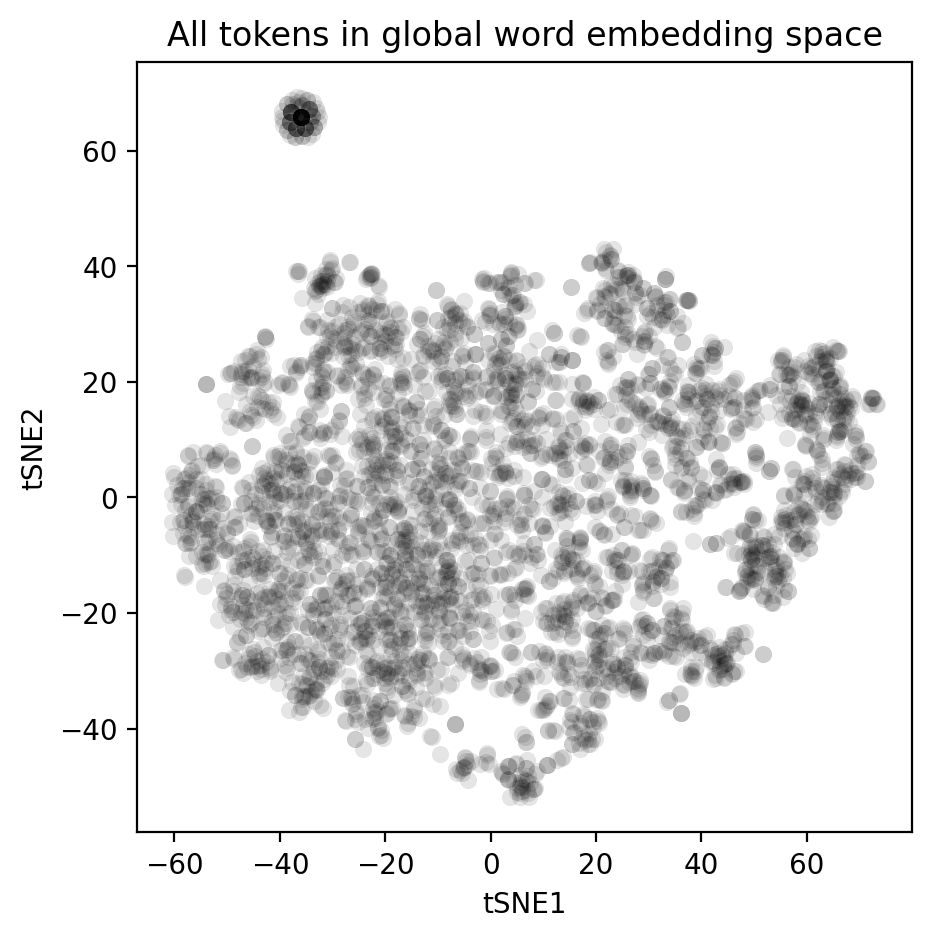

In [122]:
plt.figure(figsize=(5, 5))
plt.scatter(xs, ys, linewidths=0.1, color='black', alpha=0.1)
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.title('All tokens in global word embedding space')
plt.show()

In [123]:
from pysrc.papers.utils import factors_colormap
import matplotlib.pyplot as plt
from pysrc.papers.plot.plot_preprocessor import PlotPreprocessor
from pysrc.papers.analysis.topics import get_topics_description
from itertools import chain

data = analyzer

n = 10

print('Show words for components')
topics_description = get_topics_description(
            data.df,
            data.corpus, data.corpus_tokens, data.corpus_counts,
            n_words=n
        )
kwd_df = PlotPreprocessor.compute_kwds(topics_description, n)
words2show = PlotPreprocessor.topics_words(kwd_df, n)
print(words2show)

words = list(chain(*words2show.values()))
print(f'Total words {len(words)}')

Show words for components
{0: ['expressed', 'cd8+', 'subsets', 'antigens', 'cd4+', 'immunology', 'cytokine', 'phenotype', 'receptor', 'lymphocyte'], 1: ['immunoglobulins', 'child', 'tonsils', 'b-cells', 'naive', 'immunology', 'infected', 'life', 'yearly', 'pool'], 2: ['monocyte', 'elderly', 'th17', 'response', 'mouse', 'disease', 'level', 'young', 'cd16', 'subjected'], 3: ['sequence', 'repertoire', 'development', 'tissue', 'gene', 'single-cell', 'adaptive', 'selects', 'clonally', 'immune'], 4: ['value', 'normally', 'mortality', 'sample', 'longitudinal', 'reference', 'risk', 'patient', 'thymic', 'predictive'], 5: ['muscle', 'mutation', 'atlases', 'skeletal', 'transcriptome', 'single-cell', 'somatic', 'genetic', 'frailty', 'mrna'], 6: ['signaling', 'kinase', 'phosphorylated', 'pathway', 'telomerase', 'transcription', 'switched', 'defective', 'mitochondrial', 'factor'], 7: ['vaccine', 'antibody', 'influenza', 'ctfh', 'humoral', 'h1n1', 'efficacy', 'formation', 'vaccine-specific', 'history

/Users/Oleg.Shpynov/work/pubtrends/pysrc/papers/plot/plot_preprocessor.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  comp, kwds = row[0], row[1]


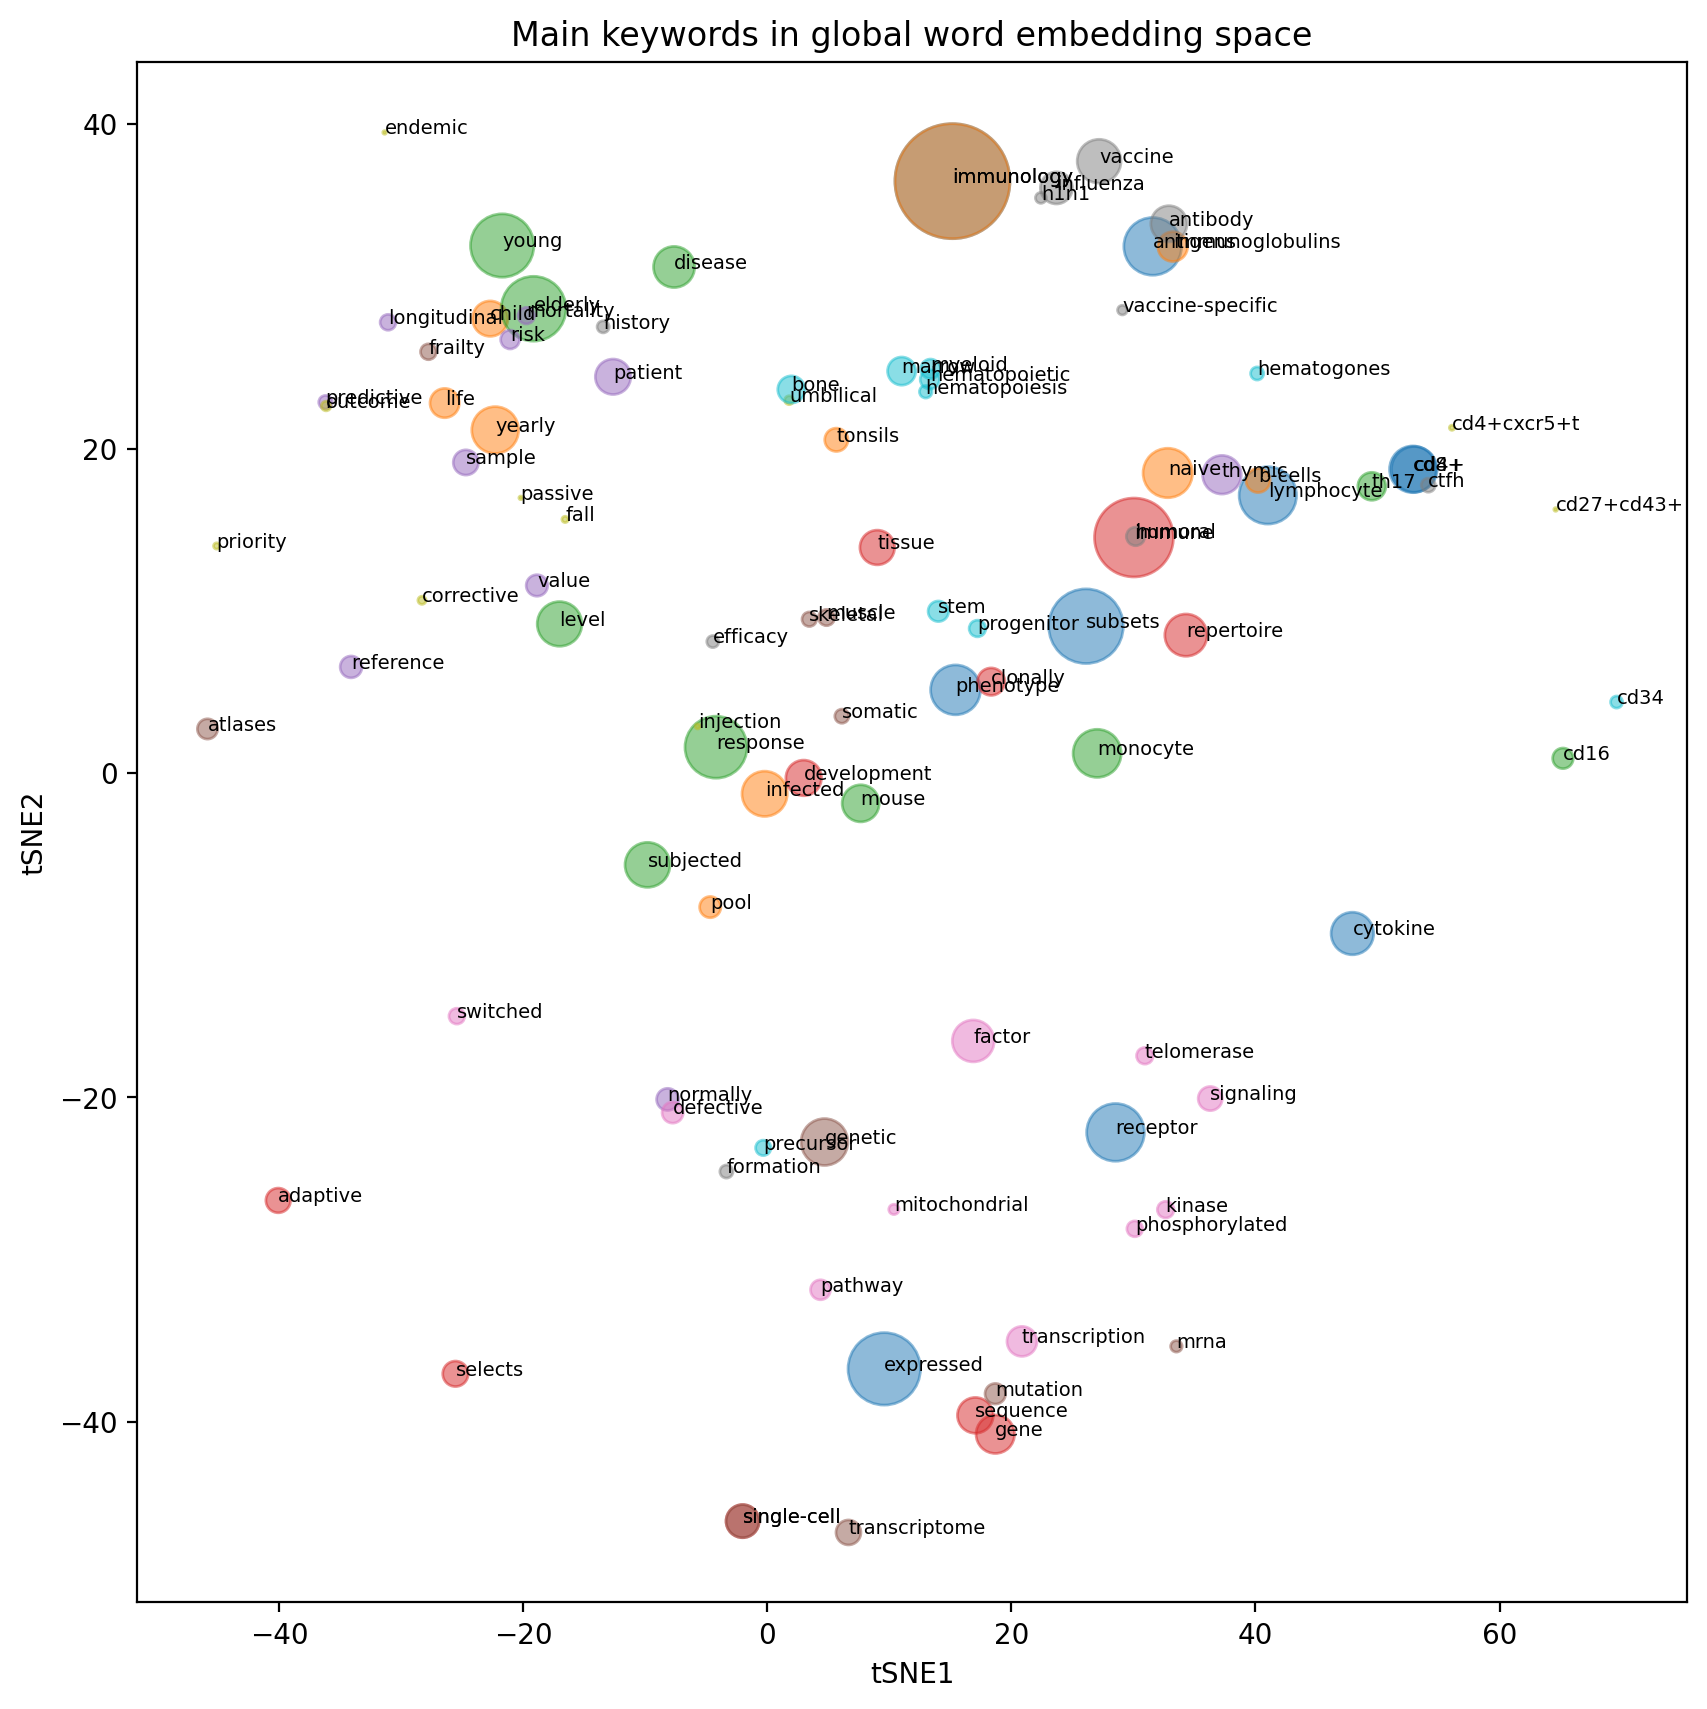

In [124]:
wxs = [xs[analyzer.corpus_tokens.index(w)] for w in words]
wys = [ys[analyzer.corpus_tokens.index(w)] for w in words]

cmap = factors_colormap(len(words2show))
colors = []
sizes = [analyzer.corpus_counts[:, analyzer.corpus_tokens.index(w)].sum() / len(analyzer.df) * 500
         for w in words]
for i, ws in words2show.items():
    colors.extend([cmap(i)] * len(ws))

plt.figure(figsize=(10, 10))
plt.scatter(wxs, wys, sizes=sizes, color=colors, alpha=0.5)
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.title('Main keywords in global word embedding space')

for word, x, y in zip(words, wxs, wys):
    plt.annotate(word, xy=(x, y - 0.1), size=7)
plt.show()

## Topics visualization in embedded space

In [125]:
comp_pids = analyzer.df[['id', 'comp']].groupby('comp')['id'].apply(list).to_dict()
terms_freqs_per_comp = np.zeros(shape=(len(words2show), analyzer.corpus_counts.shape[1]), dtype=float)
for comp, pids in comp_pids.items():
    terms_freqs_per_comp[comp, :] = np.sum(analyzer.corpus_counts[np.flatnonzero(analyzer.df['id'].isin(pids)), :],
                                           axis=0) / len(pids)
print(terms_freqs_per_comp.shape)

(10, 3745)


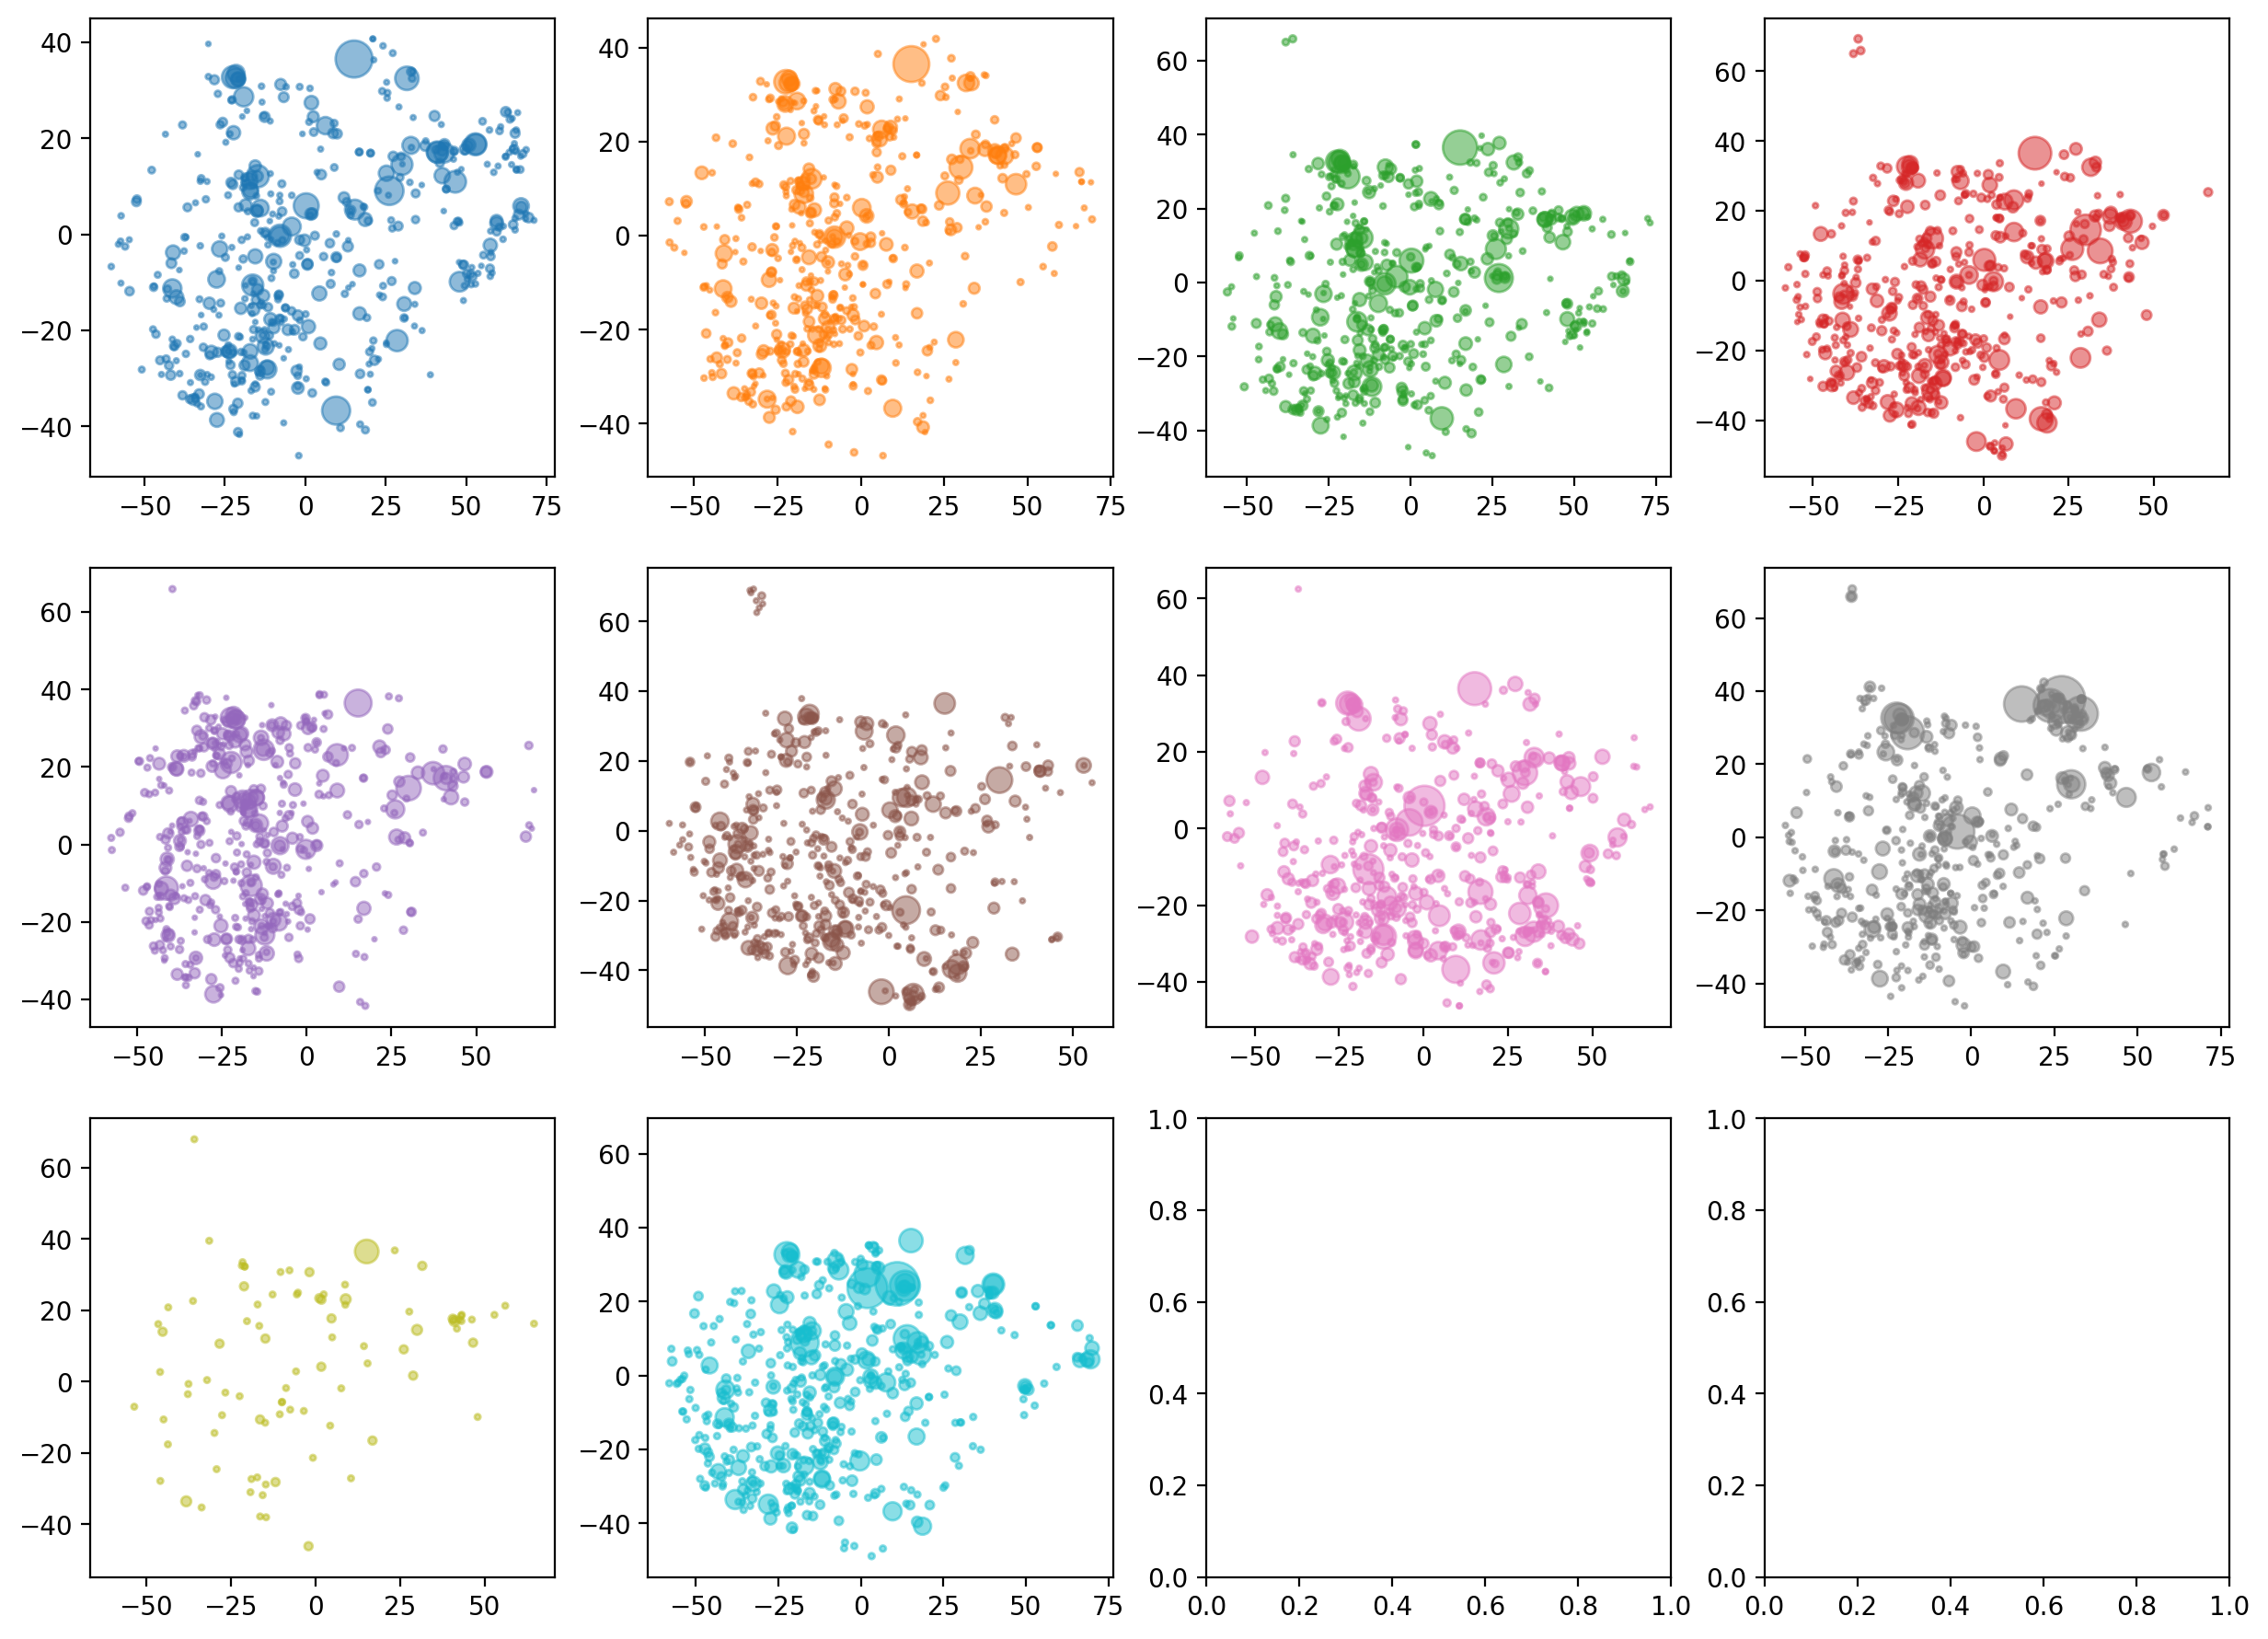

In [126]:
import math

n = 500

ncols = 4
nrows = int(math.ceil(len(comp_pids) / ncols))
plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, int(15 * nrows / ncols)))
for comp, _ in comp_pids.items():
    freqs = terms_freqs_per_comp[comp, :]
    freq_keywords_indx = freqs.argsort()[-n:][::-1]
    ax = plt.subplot(nrows, ncols, comp + 1)
    wxs = [xs[i] for i in freq_keywords_indx]
    wys = [ys[i] for i in freq_keywords_indx]
    words = [analyzer.corpus_tokens[i] for i in freq_keywords_indx]
    sizes = [freqs[i] * 50 for i in freq_keywords_indx]
    ax.scatter(wxs, wys, marker='o', sizes=sizes, color=cmap(comp), alpha=0.5)
#     plt.xlabel('tSNE1')
#     plt.ylabel('tSNE2')
#     plt.title(f'Topic {comp + 1} papers frequent keywords in global word embedding space')
#     for word, x, y in zip(words, wxs, wys):
#         plt.annotate(word, xy=(x, y-0.1))
plt.show()

# Authors analysis

In [127]:
from pysrc.papers.utils import cut_authors_list, color_to_rgb


def plot_embeddings(df, clusters):
    cmap = factors_colormap(len(set(clusters)))
    palette = dict(zip(sorted(set(clusters)), [color_to_rgb(cmap(i)).to_hex()
                                               for i in range(len(set(clusters)))]))

    df['size'] = 5 + df['total'] / df['total'].max() * 20

    # Split authors
    df['authors'] = df['authors'].apply(lambda authors: cut_authors_list(authors))

    ds = ColumnDataSource(df)
    # Add clusters coloring
    ds.add([palette[c] for c in clusters], 'color')
    p = figure(width=600, height=600,
               tools="hover,pan,tap,wheel_zoom,box_zoom,reset,save")
    p.sizing_mode = 'stretch_width'
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'y'

    p.hover.tooltips = plotter._paper_html_tooltips([
        ("Author(s)", '@authors'),
        ("Journal", '@journal'),
        ("Year", '@year'),
        ("Type", '@type'),
        ("Cited by", '@total paper(s) total'),
        ("Topic", '@comp')])
    p.scatter(x='x', y='y', fill_alpha=0.8, source=ds, size='size',
             line_color='black', fill_color='color', legend_field='comp')
    p.legend.visible = False
    show(p)

In [128]:
def fa(authors, first_last_only=True):
    return authors if len(authors) <= 2 or not first_last_only else [authors[0], authors[-1]]

## Authors graph

In [129]:
def compute_authors_citations_and_papers(df):
    logger.debug('Compute author citations')
    author_citations = {}
    for i, row in tqdm(df[['authors', 'total']].iterrows()):
        authors = fa(row['authors'].split(', '))
        for a in authors:
            author_citations[a] = author_citations.get(a, 0) + row['total']

    logger.debug('Compute number of papers per author')
    author_papers = {}
    for i, row in df[['id', 'title', 'authors']].iterrows():
        pmid = row['id']
        authors = fa(row['authors'].split(', '))
        for a in authors:
            if a not in author_papers:
                author_papers[a] = []    
            author_papers[a].append(pmid)

    return author_citations, author_papers

In [130]:
logging.info("Analyzing top 20% of authors")
authors_citations, authors_papers = compute_authors_citations_and_papers(analyzer.df)
logging.info(f"Total first and last authors {len(authors_papers)}")
min_threshold = np.percentile([len(ps) for ps in authors_papers.values()], 80)
logging.info(f'Min papers for author {min_threshold}')
logging.info(f'Filtered authors: {sum(len(v) >= min_threshold for v in authors_papers.values())}')

2025-04-02 14:08:01,777 INFO: Analyzing top 20% of authors
292it [00:00, 36629.28it/s]
2025-04-02 14:08:01,794 INFO: Total first and last authors 472
2025-04-02 14:08:01,795 INFO: Min papers for author 1.0
2025-04-02 14:08:01,795 INFO: Filtered authors: 472


In [131]:
import networkx as nx


def build_authors_similarity_graph(df,
                                   cocit_grouped_df, bibcoupling_df, cit_df,
                                   check_author_func=lambda a: True):
    logger.debug('Processing papers')
    result = nx.Graph()
    for _, row in tqdm(df[['authors']].iterrows()):
        authors = fa(row[0].split(', '))
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                a1 = authors[i]
                a2 = authors[j]
                if check_author_func(a1) and check_author_func(a2):
                    update_edge(result, a1, a2, 'authorship', 1)

    logger.debug('Processing co-citations')
    for el in tqdm(cocit_grouped_df[['cited_1', 'cited_2', 'total']].values):
        start, end, cocitation = str(el[0]), str(el[1]), float(el[2])
        authors1 = fa(df.loc[df['id'] == start]['authors'].values[0].split(', '))
        authors2 = fa(df.loc[df['id'] == end]['authors'].values[0].split(', '))
        for a1, a2 in itertools.product(authors1, authors2):
            if check_author_func(a1) and check_author_func(a2):
                update_edge(result, a1, a2, 'cocitation', cocitation)

    logger.debug('Bibliographic coupling')
    if len(bibcoupling_df) > 0:
        for el in tqdm(bibcoupling_df[['citing_1', 'citing_2', 'total']].values):
            start, end, bibcoupling = str(el[0]), str(el[1]), float(el[2])
            authors1 = fa(df.loc[df['id'] == start]['authors'].values[0].split(', '))
            authors2 = fa(df.loc[df['id'] == end]['authors'].values[0].split(', '))
            for a1, a2 in itertools.product(authors1, authors2):
                if check_author_func(a1) and check_author_func(a2):
                    update_edge(result, a1, a2, 'bibcoupling', bibcoupling)

    logger.debug('Citations')
    # Citations
    for start, end in zip(cit_df['id_out'], cit_df['id_in']):
        authors1 = fa(df.loc[df['id'] == start]['authors'].values[0].split(', '))
        authors2 = fa(df.loc[df['id'] == end]['authors'].values[0].split(', '))
        for a1, a2 in itertools.product(authors1, authors2):
            if check_author_func(a1) and check_author_func(a2):
                update_edge(result, a1, a2, 'citation', 1)

    return result


def update_edge(graph, a1, a2, name, value):
    if a1 == a2:
        return
    if a1 > a2:
        a1, a2 = a2, a1
    if not graph.has_edge(a1, a2):
        graph.add_edge(a1, a2)
    edge = graph[a1][a2]
    edge[name] = edge.get(name, 0) + value

In [132]:
import itertools

logger = logging.getLogger('Test')

authors_similarity_graph = build_authors_similarity_graph(
    analyzer.df, analyzer.cocit_grouped_df,
    analyzer.bibliographic_coupling_df,
    analyzer.cit_df,
    check_author_func=lambda a: len(authors_papers[a]) >= min_threshold
)

logging.info(f'Built authors graph - '
             f'{len(authors_similarity_graph.nodes())} nodes and {len(authors_similarity_graph.edges())} edges')

/var/folders/rt/nsqqlhj11jjc4_9chghc33j00000gn/T/ipykernel_83733/2532533235.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  authors = fa(row[0].split(', '))
292it [00:00, 48128.93it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 1731.02it/s]
2025-04-02 14:08:04,620 INFO: Built authors graph - 470 nodes and 13460 edges


## Node2vec embeddings for authors graph

In [133]:
from pysrc.papers.analysis.node2vec import node2vec
from pysrc.papers.analysis.graph import sparse_graph, similarity

def to_weighted_graph(graph, weight_func, key='weight'):
    logger.debug('Creating weighted graph')
    g = nx.Graph()
    for u, v, data in graph.edges(data=True):
        w = weight_func(data)
        if np.isnan(w):
            raise Exception(f'Weight is NaN {w}')
        elif w < 0:
            raise Exception(f'Weight is < 0 {w}')
        elif w != 0:
            g.add_edge(u, v, **{key: w})
    # Ensure all the nodes present
    for v in graph.nodes:
        if not g.has_node(v):
            g.add_node(v)
    return g


logger.debug('Compute aggregated similarity using co-authorship')
ga = to_weighted_graph(authors_similarity_graph,
                       weight_func=lambda d: 100 * d.get('authorship', 0) + similarity(d))
gs = sparse_graph(ga, 10)
authors_node_ids = list(authors_similarity_graph.nodes)
authors_weighted_node_embeddings = node2vec(authors_node_ids, gs)
print(authors_weighted_node_embeddings.shape)

2025-04-02 14:08:23,184 INFO: collecting all words and their counts
2025-04-02 14:08:23,185 INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-04-02 14:08:23,214 INFO: PROGRESS: at sentence #10000, processed 479420 words, keeping 470 word types
2025-04-02 14:08:23,243 INFO: PROGRESS: at sentence #20000, processed 958840 words, keeping 470 word types
2025-04-02 14:08:23,273 INFO: PROGRESS: at sentence #30000, processed 1438260 words, keeping 470 word types
2025-04-02 14:08:23,301 INFO: PROGRESS: at sentence #40000, processed 1916700 words, keeping 470 word types
2025-04-02 14:08:23,321 INFO: collected 470 word types from a corpus of 2252000 raw words and 47000 sentences
2025-04-02 14:08:23,321 INFO: Creating a fresh vocabulary
2025-04-02 14:08:23,322 INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 470 unique words (100.00% of original 470, drops 0)', 'datetime': '2025-04-02T14:08:23.322265', 'gensim': '4.3.3', 'python': '3.10.16 | packaged

(470, 200)


## Authors papers embeddings

In [134]:
from pysrc.papers.analysis.text import texts_embeddings
papers_text_embeddings = texts_embeddings(
    analyzer.corpus_counts, analyzer.corpus_tokens_embedding
)
print(papers_text_embeddings.shape)

(292, 200)


In [135]:
authors_node_ids = list(authors_similarity_graph.nodes)
papers_idx = {pmid: idx for idx, pmid in enumerate(analyzer.df['id'])}
authors_papers_embeddings = np.zeros((len(authors_node_ids), papers_text_embeddings.shape[1]))
for i, a in enumerate(authors_node_ids):
    for pmid in authors_papers[a]:
        authors_papers_embeddings[i, :] += papers_text_embeddings[papers_idx[pmid], :]
    authors_papers_embeddings[i, :] /= len(authors_papers[a])
authors_papers_embeddings.shape

(470, 200)

## Merge embeddings

In [136]:
from pysrc.config import *
authors_embeddings = (authors_weighted_node_embeddings * GRAPH_EMBEDDINGS_FACTOR +
                      authors_papers_embeddings * TEXT_EMBEDDINGS_FACTOR
                      ) / (GRAPH_EMBEDDINGS_FACTOR + TEXT_EMBEDDINGS_FACTOR)

## Plot

In [137]:
AUTHORS_HIGHLIGTHS = ['Terekhova M', 'Artyomov MN']

In [138]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

logger.debug('Computing PCA projection')
pca = PCA(n_components=min(len(authors_embeddings), PCA_COMPONENTS))
t = StandardScaler().fit_transform(authors_embeddings)
authors_pca_coords = pca.fit_transform(t)
logger.debug(f'Explained variation {int(np.sum(pca.explained_variance_ratio_) * 100)}%')

logger.debug('Apply t-SNE transformation on node embeddings')
authors_tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, authors_pca_coords.shape[0] - 1))
authors_weighted_node_embeddings_2d = authors_tsne.fit_transform(authors_pca_coords)

In [139]:
# Build dataframe combining information about authors and projected coordinates
authors_df = pd.DataFrame(dict(author=authors_node_ids,
                               x=authors_weighted_node_embeddings_2d[:, 0],
                               y=authors_weighted_node_embeddings_2d[:, 1]))
authors_df['cited'] = [authors_citations[a] for a in authors_df['author']]
authors_df['papers'] = [authors_papers[a] for a in authors_df['author']]
authors_df['size'] = [1 + 10 * np.log1p(authors_citations[a]) for a in authors_df['author']]
# Limit max size
authors_df['size'] = authors_df['size'] * 10 / authors_df['size'].max() + 3

In [140]:
from bokeh.models import LabelSet, Label


def plot_authors(authors_df, highlights=[], groups_topics=None, width=600, height=600):
    clusters = set(authors_df['cluster'])
    cmap = factors_colormap(len(clusters))
    palette = dict(zip(sorted(clusters),
                       [color_to_rgb(cmap(i)).to_hex() for i in range(len(clusters))]))
    authors_df['color'] = [palette[c] for c in authors_df['cluster']]
    authors_df['line_width'] = [3 if a in highlights else 1 for a in authors_df['author']]
    ds = ColumnDataSource(authors_df)
    del authors_df['color'], authors_df['line_width']
    x = authors_df['x']
    y = authors_df['y']
    xrange = max(x) - min(x)
    yrange = max(y) - min(y)
    p = figure(width=width, height=height,
               x_range=(min(x) - 0.05 * xrange, max(x) + 0.05 * xrange),
               y_range=(min(y) - 0.05 * yrange, max(y) + 0.05 * yrange),
               tools="hover,pan,tap,wheel_zoom,box_zoom,reset,save",
               tooltips=[("Author", '@author'),
                         ("Papers", '@papers'),
                         ("Cited by", '@cited'),
                         ("Cluster", '@cluster'),
                         ("Tags", '@tags')])

    p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
    p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
    p.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
    p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
    p.xaxis.major_label_text_font_size = '0pt'  # preferred method for removing tick labels
    p.yaxis.major_label_text_font_size = '0pt'  # preferred method for removing tick labels
    p.grid.grid_line_color = None
    p.outline_line_color = None
    p.sizing_mode = 'stretch_width'

    p.scatter(source=ds, x='x', y='y', fill_alpha=0.8, size='size', line_width='line_width',
             line_color='black', fill_color='color')

    lxs = [authors_df.loc[authors_df['cluster'] == c]['x'].mean() for c in sorted(clusters)]
    lys = [authors_df.loc[authors_df['cluster'] == c]['y'].mean() for c in sorted(clusters)]
    cluster_labels = [f'#{c + 1}' for c in sorted(clusters)]
    source = ColumnDataSource({'x': lxs, 'y': lys, 'name': cluster_labels})
    labels = LabelSet(x='x', y='y', text='name', source=source,
                      background_fill_color='white', text_font_size='11px', background_fill_alpha=.9)
    p.renderers.append(labels)
    for i, c in enumerate(sorted(clusters)):
        p.rect(x=min(x), y=max(y) - i * 2, width=1, height=2, fill_color=palette[c], line_color=None)
        if groups_topics is not None:
            text = f"#{c + 1} {', '.join(t for t, _ in groups_topics[c][:5])}"
        else:
            text = f"#{c + 1}"
        p.add_layout(Label(
                    x=min(x) + 1, y=max(y) - 1 - i * 2,
                    text=text,
                    text_font_size='11px',
                    text_align="left",
                    background_fill_color="white",
                    background_fill_alpha=0.7,
                ))
    return p

In [150]:
authors_df['cluster'] = 0
authors_df['tags'] = 'n/a'
show(plot_authors(authors_df, highlights=AUTHORS_HIGHLIGTHS))

## Authors clustering

2025-04-02 14:08:48,253 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-02 14:08:48,256 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Cophenetic Correlation Coefficient: 0.349610484469881
Cluster sizes


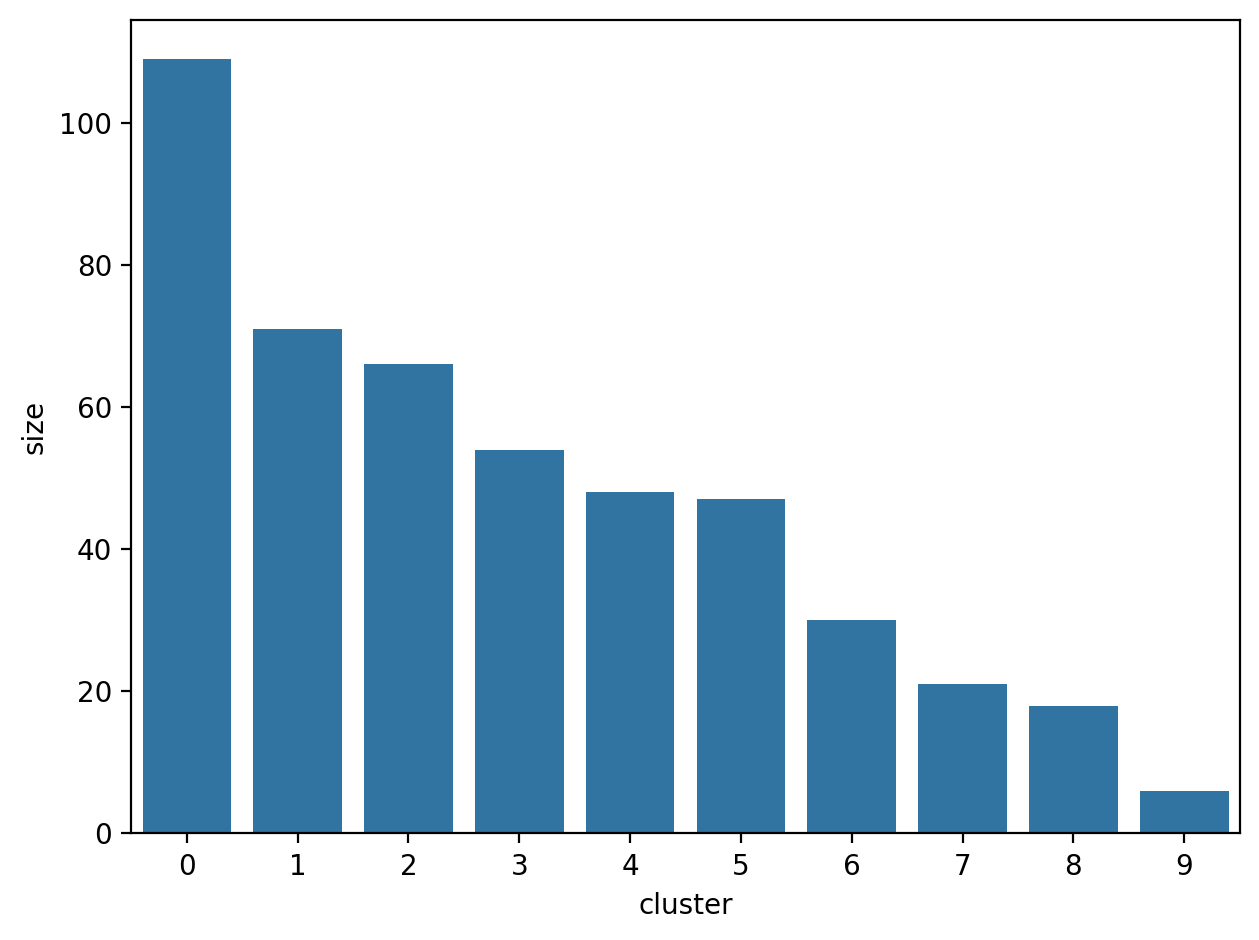

In [142]:
from pysrc.papers.analysis.topics import cluster_and_sort

author_clusters, _ = cluster_and_sort(authors_pca_coords, 10, 5)
authors_df['cluster'] = author_clusters

print('Cluster sizes')
t = pd.DataFrame({'cluster': author_clusters,
                  'size': np.ones(len(author_clusters))}).groupby(['cluster']).sum().astype(int).reset_index()
sns.barplot(data=t, x='cluster', y='size')
plt.tight_layout()
plt.show()

In [143]:
show(plot_authors(authors_df, highlights=AUTHORS_HIGHLIGTHS))

## Analyze authors group topics

In [144]:
from sklearn.feature_extraction.text import TfidfTransformer


def compute_tfidf(corpus_counts):
    logger.debug('Compute TF-IDF on tokens counts')
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(corpus_counts)
    logger.debug(f'TFIDF shape {tfidf.shape}')
    return tfidf


def compute_groups_topics(authors_df):
    logging.info('Computing groups of authors topics')
    groups_counts = np.zeros(shape=(len(set(authors_df['cluster'])), analyzer.corpus_counts.shape[1]), dtype=np.float64)

    part_sizes = Counter(authors_df['cluster'])
    authors_clusters_map = dict(zip(authors_df['author'], authors_df['cluster']))

    for i, row in tqdm(analyzer.df[['authors']].iterrows()):
        for a in row[0].split(', '):
            if a in authors_clusters_map:
                group = authors_clusters_map[a]
                groups_counts[group, :] += analyzer.corpus_counts[i, :] / part_sizes[group]

    tfidf = compute_tfidf(groups_counts)

    logging.info('Take terms with the largest tfidf for topics')
    result = {}
    for g in range(groups_counts.shape[0]):
        counter = Counter()
        for i, t in enumerate(analyzer.corpus_tokens):
            counter[t] += tfidf[g, i]
        # Ignore terms with insignificant frequencies
        result[g] = [(t, f) for t, f in counter.most_common(10) if f > 0]
    return result



groups_topics = compute_groups_topics(authors_df)
kwds = [(g, ','.join(f'{t}:{v:.3f}' for t, v in vs)) for g, vs in groups_topics.items()]
logging.info('Description\n' + '\n'.join(f'{g}: {kwd}' for g, kwd in kwds))


2025-04-02 14:08:48,665 INFO: Computing groups of authors topics
/var/folders/rt/nsqqlhj11jjc4_9chghc33j00000gn/T/ipykernel_83733/2769071751.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for a in row[0].split(', '):
292it [00:00, 4880.17it/s]
2025-04-02 14:08:48,728 INFO: Take terms with the largest tfidf for topics
2025-04-02 14:08:48,968 INFO: Description
0: immunology:0.374,immune:0.204,blood:0.181,metabolic:0.177,adult:0.167,expressed:0.164,th17:0.157,subsets:0.137,young:0.133,elderly:0.129
1: immunology:0.411,immune:0.256,repertoire:0.190,adult:0.179,subsets:0.170,t-cells:0.141,elderly:0.139,metabolic:0.129,change:0.128,memory:0.123
2: immunology:0.388,metabolic:0.303,expressed:0.270,increase:0.169,active:0.166,elderly:0.163,subsets:0.162,receptor:0.159,monocyte:0.156,adult:0.156
3: immuno

In [145]:
groups_df = pd.DataFrame(columns=['group', 'authors', 'keywords'], dtype=object)
for g in sorted(set(authors_df['cluster'])):
    authors = ', '.join(authors_df.loc[authors_df['cluster'] == g]['author'])
    groups_df.loc[len(groups_df)] = (g, authors, ','.join(t for t, _ in groups_topics[g]))

display(groups_df)

,group,authors,keywords
0,0,"Kwok JSY, Lau YL, Tesselaar K, den Braber I, V...","immunology,immune,blood,metabolic,adult,expres..."
1,1,"Alpert A, Shen-Orr SS, Koch S, Mogilenko DA, T...","immunology,immune,repertoire,adult,subsets,t-c..."
2,2,"Goronzy JJ, Zhang H, Pekalski ML, Wicker LS, L...","immunology,metabolic,expressed,increase,active..."
3,3,"Douek DC, Koup RA, Kimmig S, Haines CJ, Lewis ...","immunology,naive,subsets,metabolic,t-cells,mem..."
4,4,"Han JJ, Zhu H, Cunningham CA, Fink PJ, Kalina ...","immunology,immune,tissue,metabolic,thymus,spat..."
5,5,"Ferrucci L, Aita JF, Wanamaker WM, Francis IR,...","immunology,subsets,adult,tonsils,active,lympho..."
6,6,"Briceo O, vila-Ros S, Goto M, Lee E, Palmer S,...","expressed,immunology,subsets,t-cells,cd8+,infe..."
7,7,"Linterman MA, Stebegg M, Herati RS, Wherry EJ,...","vaccine,influenza,immunology,antibody,response..."
8,8,"Pang WW, Weissman IL, Chatta GS, Dale DC, Kinc...","marrow,bone,hematopoietic,hematogones,change,s..."
9,9,"Kuchel GA, Klenerman P, Walker LJ, Descatoire ...","immunology,immune,sex,spike,mait,priority,t-ly..."


In [146]:
authors_df['tags'] = [', '.join(f'{t}:{v:.3f}' for t, v in groups_topics[c][:5]) for c in authors_df['cluster']]
show(plot_authors(authors_df, highlights=AUTHORS_HIGHLIGTHS, groups_topics=groups_topics))

In [151]:
logging.info('Saving author groups graph for bokeh')
output_file(filename=os.path.expanduser("~/authors.html"), title="Authors similarity graph")
save(plot_authors(authors_df, width=1600, height=1200))
reset_output()
output_notebook()

2025-04-02 14:10:54,925 INFO: Saving author groups graph for bokeh


Loading BokehJS ...

### Use ego-splitting to compute possible overlapping groups of authors
Taken from https://github.com/benedekrozemberczki/EgoSplitting

In [148]:
import community
from tqdm import tqdm


class EgoNetSplitter(object):
    """An implementation of `"Ego-Splitting" see:
    https://www.eecs.yorku.ca/course_archive/2017-18/F/6412/reading/kdd17p145.pdf
    From the KDD '17 paper "Ego-Splitting Framework: from Non-Overlapping to Overlapping Clusters".
    The tool first creates the egonets of nodes.
    A persona-graph is created which is clustered by the Louvain method.
    The resulting overlapping cluster memberships are stored as a dictionary.
    Args:
        resolution (float): Resolution parameter of Python Louvain. Default 1.0.
    """

    def __init__(self, resolution=1.0):
        self.resolution = resolution

    def _create_egonet(self, node):
        """
        Creating an ego net, extracting personas and partitioning it.

        Args:
            node: Node ID for egonet (ego node).
        """
        ego_net_minus_ego = self.graph.subgraph(self.graph.neighbors(node))
        components = {i: n for i, n in enumerate(nx.connected_components(ego_net_minus_ego))}
        new_mapping = {}
        personalities = []
        for k, v in components.items():
            personalities.append(self.index)
            for other_node in v:
                new_mapping[other_node] = self.index
            self.index = self.index + 1
        self.components[node] = new_mapping
        self.personalities[node] = personalities

    def _create_egonets(self):
        """
        Creating an egonet for each node.
        """
        self.components = {}
        self.personalities = {}
        self.index = 0
        print("Creating egonets.")
        for node in tqdm(self.graph.nodes()):
            self._create_egonet(node)

    def _map_personalities(self):
        """
        Mapping the personas to new nodes.
        """
        self.personality_map = {p: n for n in self.graph.nodes() for p in self.personalities[n]}

    def _get_new_edge_ids(self, edge):
        """
        Getting the new edge identifiers.
        Args:
            edge: Edge being mapped to the new identifiers.
        """
        return self.components[edge[0]][edge[1]], self.components[edge[1]][edge[0]]

    def _create_persona_graph(self):
        """
        Create a persona graph using the egonet components.
        """
        print("Creating the persona graph.")
        self.persona_graph_edges = [self._get_new_edge_ids(e) for e in tqdm(self.graph.edges())]
        self.persona_graph = nx.from_edgelist(self.persona_graph_edges)

    def _create_partitions(self):
        """
        Creating a non-overlapping clustering of nodes in the persona graph.
        """
        print("Clustering the persona graph.")
        self.partitions = community.best_partition(self.persona_graph, resolution=self.resolution)
        self.overlapping_partitions = {node: [] for node in self.graph.nodes()}
        for node, membership in self.partitions.items():
            self.overlapping_partitions[self.personality_map[node]].append(membership)

    def fit(self, graph):
        """
        Fitting an Ego-Splitter clustering model.

        Arg types:
            * **graph** *(NetworkX graph)* - The graph to be clustered.
        """
        self.graph = graph
        self._create_egonets()
        self._map_personalities()
        self._create_persona_graph()
        self._create_partitions()

    def get_memberships(self):
        r"""Getting the cluster membership of nodes.
        Return types:
            * **memberships** *(dictionary of lists)* - Cluster memberships.
        """
        return self.overlapping_partitions


In [149]:
splitter = EgoNetSplitter(0.8)
splitter.fit(authors_similarity_graph)

ego_clusters = []
for a, cs in splitter.overlapping_partitions.items():
    ego_clusters.extend(cs)
print('Total clusters', len(set(ego_clusters)))
print('Clusters', Counter(ego_clusters))
print(len(authors_similarity_graph.nodes()))
print(len(ego_clusters))

Creating egonets.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [00:00<00:00, 3473.68it/s]


Creating the persona graph.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13460/13460 [00:00<00:00, 2312321.60it/s]

Clustering the persona graph.
Total clusters 30
Clusters Counter({4: 159, 12: 88, 27: 87, 28: 34, 1: 21, 29: 18, 6: 8, 23: 5, 5: 4, 24: 4, 22: 4, 8: 3, 0: 3, 7: 2, 18: 2, 9: 2, 10: 2, 11: 2, 13: 2, 14: 2, 15: 2, 3: 2, 16: 2, 17: 2, 19: 2, 21: 2, 20: 2, 2: 2, 25: 2, 26: 2})
470
472
